# OSMuf (OpenStreetMap urban form)
## version 0.1 - September 2019
OSMuf is a Python library for measuring urban form from OpenStreetMap. It is inspired by and builds on [Geoff Boeing's OSMnx](https://github.com/gboeing).

Where OSMnx quantifies urban form in terms of the street network, OSMuf aims to quantify urban form by buildings and land use. Its primary aim is to generate a minimum set of metrics for comparing urban form between cities making it possible to investigate the relationship between buildings, urban blocks and the street network.

It focuses uniquely at the scale of the urban block, using the definition of urban blocks as the islands of contiguous plots separated by public highway. In other words, the edge of an urban block follows the line where private land meets public highway. It also uses gross urban blocks to investigate the relationship between the street network and gross building density. This gross definition expands the (net) urban block to the centreline of the surrounding streets.

### Proof-of-concept
Version 0.1 is a proof-of-concept release. It is not intended for wide-scale application but rather to demonstrate that useful measures of building density and urban form can be made from OpenStreetMap. This preliminary release relies on OSM having the outlines of urban blocks drawn and tagged as `city_block=yes`. While this follows OSM guidlines, it is not common. It is intended that the next version of OSMuf will be able to generate urban blocks from contiguous land use areas alone. Because of this limitation, OSMuf is currently limited to the four sample areas defined in the `places` dictionary below.

### Preliminary Data Analysis
The visualisations produced, particularly the graphs, are in an early stage of development. However they already suggest that relationships between the various metrics can usefully be identified from the OpenStreetMap data. 

In [1]:
# dictionary of sample areas that include city_block polygons
places = {'Buenos Aires':(-34.5798,-58.4422),
          'Clerkenwell':(51.5273,-0.1109),
          'Welwyn Garden City':(51.7938,-0.189),
          'Bromley':(51.395,-0.006)
         }
# distance from centre of bounding box to edge
distance = 500

In [2]:
# dpi for the saved visualisations
dpi = 100

### Integration with OSMnx
To avoid duplicating effort, OSMnx's functions for accessing OSM data, reprojecting it, etc. are used directly. This close reliance on OSMnx opens the way to investigating possible relationships between building density and network centrality (for example).

In [3]:
import osmuf as ouf
import osmnx as ox

## 1. Download and project primary OSM data
- Define a study area from point and distance
- Download OSM polygons tagged as 'place' from the same point and distance. Keep only those tagged as "place=city_block"
- Download OSM buildings and filter the attributes to the minimum
- Download OSM streets that overlap the city blocks - this is to ensure all of the buildings on a city block are downloaded and not clipped to the study area

### Select sample area from the dictionary above

In [4]:
# choose one of the study areas by name
place_name = 'Bromley'
# make point equal to its coordinates
point = places[place_name]

### Draw the bounding box & download urban blocks that intersect with it
- the bounding box provides a fixed-size visual reference
- it also acts as the crop for the images later on
- the urban blocks are downloaded using the same centre point and offset distance

In [5]:
# define study area
study_area = ouf.study_area_from_point(point, distance)

# include projected version temporarily to deal with rotation
study_area_prj = ouf.projected_study_area_from_point(point, distance)

# download urban blocks
city_blocks = ouf.places_from_point(point, distance)

/home/nick/anaconda3/envs/osmuf-dev/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/nick/anaconda3/envs/osmuf-dev/lib/python3.7/site-packages/osmnx/footprints.py:44: UserWarning: The `footprints` module has been deprecated and will be removed in a future release. Instead, use the `geometries` module's `geometries_from_point` function, passing `tags={'building':True}`.
  warnings.warn(msg)


<AxesSubplot:>

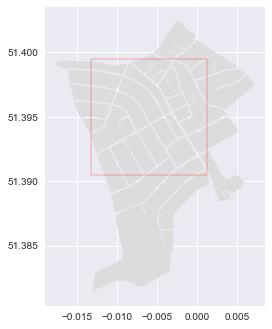

In [6]:
# show the city blocks and study area. note: these are unprojected at this stage
ax = city_blocks.plot(color='gainsboro')
study_area.plot(ax=ax, facecolor='none', edgecolor='red')

In [7]:
city_blocks.head()

,city_block_id,place,geometry
0,0,city_block,"POLYGON ((-0.01094 51.39255, -0.01105 51.39256..."
1,1,city_block,"POLYGON ((-0.00654 51.39054, -0.00650 51.39053..."
2,2,city_block,"POLYGON ((-0.00499 51.39132, -0.00493 51.39130..."
3,3,city_block,"POLYGON ((-0.00393 51.39260, -0.00385 51.39261..."
4,4,city_block,"POLYGON ((-0.00230 51.39332, -0.00157 51.39357..."


### Download buildings and streets for the urban blocks
- buildings and streets need to be downloaded for the entirety of the urban blocks
- therefore OSMuf uses a buffered convex hull around the urban blocks not the bounding box
- OSMuf currently downloads highways twice:
  1. ALL highways are polygonised into gross urban blocks
  2. driveable highways are used to calculate network metrics

In [8]:
# download buildings on the urban blocks
buildings = ouf.buildings_from_gdf(city_blocks)

# download all highways around the urban blocks to polygonise into gross urban blocks
street_graph_for_blocks = ouf.street_graph_from_gdf(city_blocks)
streets_for_blocks = ouf.streets_from_street_graph(street_graph_for_blocks)

# download driveable streets to generate network metrics
street_graph_for_networkd = ouf.street_graph_from_gdf(city_blocks,
                                                      network_type='drive')
streets_for_networkd = ouf.streets_from_street_graph(street_graph_for_networkd)

/home/nick/anaconda3/envs/osmuf-dev/lib/python3.7/site-packages/osmnx/footprints.py:166: UserWarning: The `footprints` module has been deprecated and will be removed in a future release. Instead, use the `geometries` module's `geometries_from_polygon` function, passing `tags={'building':True}`.
  warnings.warn(msg)


### Project the dataframes to UTM
- project the coordinates from geographic (lat, long) to UTM (meters)
- makes it possible to measure length and area directly from the geometry

In [9]:
# project the dataframes to local UTM coordinates
city_blocks_prj = ox.project_gdf(city_blocks)
streets_for_blocks_prj = ox.project_gdf(streets_for_blocks)
streets_for_networkd_prj = ox.project_gdf(streets_for_networkd)
buildings_prj = ox.project_gdf(buildings)

### Plot the dataframes
- visually inspect the data that has been downloaded
- check they are all aligned

<AxesSubplot:>

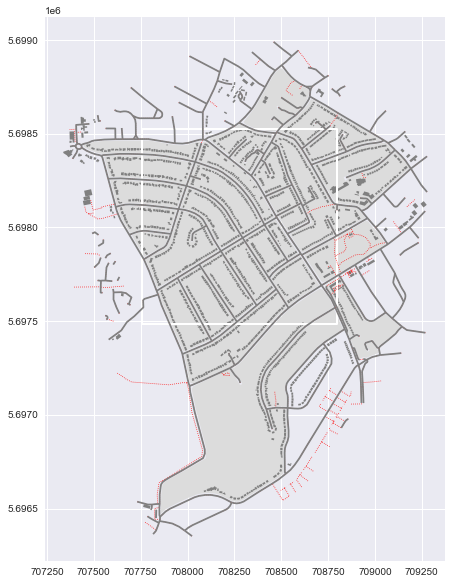

In [10]:
# display the dataframes to check their alignment
ax = city_blocks_prj.plot(figsize=(10,10), color='gainsboro')
buildings_prj.plot(ax=ax, color='grey')
streets_for_blocks_prj.plot(ax=ax, color='red', linewidth=0.75, linestyle=':')
streets_for_networkd_prj.plot(ax=ax, color='grey')
study_area_prj.plot(ax=ax, edgecolor='white',facecolor='None', linewidth=2)

## 2. Generate gross urban block geometry
OSMuf uses the concept of a 'gross urban block' to quantify the area of public highway land associated with each urban block.
This expands each (net) urban block to the centreline of the surrounding streets and has the effect of 'removing' cul-de-sacs. To calculate street network density including cul-de-sacs they have to be added back at later stage.

Gross urban blocks are generated by:
- using all highway ways (including pedestrian and cycle ways) this ensures that pedestrianised streets are included
- splitting the network into edge fragments and ensuring there are no duplicate edges
- polygonising the edge fragments

This creates more fragments than necessary but it was found that:
- the alternative (excluding pedestrian and cycle ways) tends to merge gross urban blocks
- the fragments can be merged by intersecting them with the (net) urban blocks downloaded first

In [11]:
# generate gross city blocks from the street graph and net city blocks
gross_city_blocks = ouf.gen_gross_city_blocks(street_graph_for_blocks,
                                              city_blocks)

# project the new gross city blocks
gross_city_blocks_prj = ox.project_gdf(gross_city_blocks)

<AxesSubplot:>

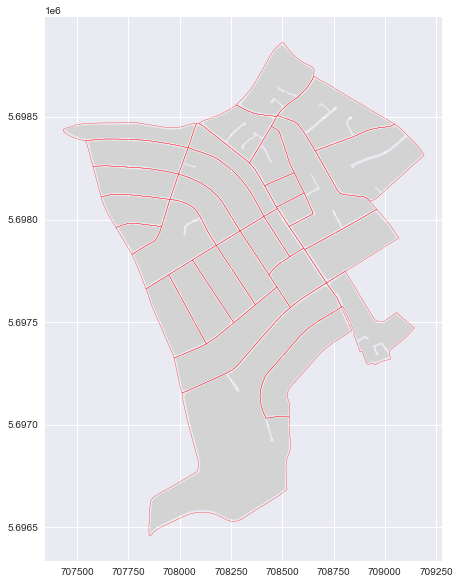

In [12]:
ax = gross_city_blocks_prj.plot(figsize=(10,10), edgecolor='red', facecolor='none')
city_blocks_prj.plot(ax=ax, edgecolor='none', facecolor='lightgrey')

## 3. Calculate metrics and ratios

## Urban Blocks
### Calculate gross urban block metrics and ratios
- `inner_streets_m` is the full length of any cul-de-sacs within each gross urban block
- `outer_streets_m` is half the length of the surrounding streets (this is to avoid double counting)
- `gross_area_ha` is the area of the gross urban block in hectares
- `network_density_m_ha` is the total length of street (inner and outer) divided by the gross block area

In [13]:
# calculate network density for each gross urban block
gross_city_blocks_prj = ouf.measure_network_density(streets_for_networkd_prj,
                                                    gross_city_blocks_prj)

gross_city_blocks_prj.head(2)

Index(['city_block_id', 'place', 'geometry', 'inner_streets_m'], dtype='object')


,city_block_id,place,geometry,inner_streets_m,outer_streets_m,gross_area_ha,network_density_m_ha
0,0,city_block,"POLYGON ((708129.872 5697393.245, 708094.786 5...",0.0,1050.95,5.7085,92.05
1,1,city_block,"POLYGON ((708062.087 5697802.766, 708178.263 5...",0.0,986.95,4.8577,101.59


### Add the gross urban block metrics and ratios onto each (net) urban block
OSMuf focuses its analysis at the scale of the (net) urban block. Therefore all metrics and ratios are merged into the `city_blocks_prj` dataframe.

In addition to the gross urban block metrics and ratios listed above this includes:
- `net_area_m2` the area of the (net) urban block
- `frontage_m` the perimeter length of the net urban block. As suggested by the name this is the total length of frontage available to the block.
- `PAR` the Perimeter:Area Ratio of the net urban block. This is also listed as the `net_frontage_density`.
- `gross_frontage_density_m_m2` the (net) urban block's frontage length (m) divided by the gross urban block's area (m2)
- `net:gross` the Net to Gross area ratio of the urban blocks. Gives an indication of the proportion of developable land and public highway land

In [14]:
# calculate the net_to_gross for the net_city_blocks
city_blocks_prj = ouf.measure_city_blocks(city_blocks_prj,
                                          gross_city_blocks_prj)

city_blocks_prj.head(2)

,city_block_id,place,net_area_m2,frontage_m,PAR,net_frontage_density_m_m2,gross_frontage_density_m_m2,gross_area_m2,inner_streets_m,outer_streets_m,network_length_m,network_density_m_ha,net:gross,geometry
0,0,city_block,50292.63,987.24,0.0196,0.0196,0.0173,57084.75,0.0,1050.95,525.48,92.05,0.88,"POLYGON ((707945.323 5697719.389, 707938.167 5..."
1,1,city_block,42523.12,923.85,0.0217,0.0217,0.0190,48577.33,0.0,986.95,493.48,101.59,0.88,"POLYGON ((708260.766 5697508.975, 708263.803 5..."


## Buildings
### Calculate building footprint (m2) and total Gross External Area (m2)
- The area of each building's footprint is measured directly from the area property of the building polygons
- Each building's total (above ground) Gross External Area is calculated by multiplying its footprint area by its height in storeys

In [15]:
# generate the footprint area and total GEA for each building
buildings_prj = ouf.measure_buildings(buildings_prj)

buildings_prj.head(2)

,building_id,building,building:levels,geometry,footprint_m2,total_GEA_m2
0,0,yes,0,"POLYGON ((707336.964 5698397.342, 707355.536 5...",1227.2,0.0
1,1,roof,0,"POLYGON ((708854.918 5697762.053, 708863.145 5...",251.9,0.0


### Add the id of the urban block to every building
- intersect the buildings with the urban blocks
- add to each building the id of the urban block that it intersects with
- this will be '0' where the building doesn't intersect with an urban block

In [16]:
# join the id of the city block onto each building
buildings_prj = ouf.join_buildings_place_id(buildings_prj,
                                            city_blocks_prj)

buildings_prj.head(2)

,building_id,building,building:levels,geometry,footprint_m2,total_GEA_m2,city_block_id
0,0,yes,0,"POLYGON ((707336.964 5698397.342, 707355.536 5...",1227.2,0.0,0
1,1,roof,0,"POLYGON ((708854.918 5697762.053, 708863.145 5...",251.9,0.0,0


### Plot buildings coloured by block id

<AxesSubplot:>

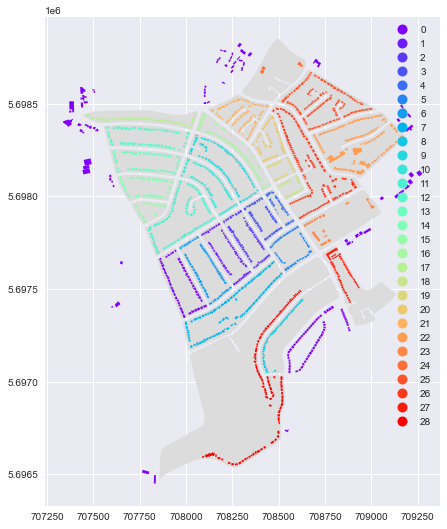

In [17]:
ax = city_blocks_prj.plot(figsize=(10,9), color='gainsboro')
buildings_prj.plot(ax=ax, column='city_block_id', cmap='rainbow',categorical=True, legend=True)

### Calculate building density ratios per urban block

This step:
- Aggregates the building footprint areas and GEAs according to the buildings' urban block id
- Joins these sum totals onto each block in the `city_block_prj` dataframe

A range of building density ratios are then calculated:
- `net_GSI` the sum total footprint divided by net urban block area. The Ground Space Index of the urban block i.e. the proportion of it that is covered by building.
- `net_FSI` the sum total GEA divided by net urban block area. The Floor Space Index of the urban block i.e. the ratio of total building gross floor area to the net urban block area.
- `gross_GSI` as `net_GSI` but calculated against the gross urban block area
- `gross_FSI` as `net_FSI` but calculated against the gross urban block area
- `avg_building:levels` the average building height per urban block. Calculated by dividing the total GEA by the total footprint area

In [18]:
# aggregate building measures and merge onto city blocks
city_blocks_prj = ouf.join_places_building_data(city_blocks_prj,
                                                buildings_prj)

city_blocks_prj.head(2)

,city_block_id,place,net_area_m2,frontage_m,PAR,net_frontage_density_m_m2,gross_frontage_density_m_m2,gross_area_m2,inner_streets_m,outer_streets_m,...,network_density_m_ha,net:gross,geometry,footprint_m2,total_GEA_m2,net_GSI,net_FSI,gross_GSI,gross_FSI,avg_building:levels
0,1,city_block,42523.12,923.85,0.0217,0.0217,0.0190,48577.33,0.0,986.95,...,101.59,0.88,"POLYGON ((708260.766 5697508.975, 708263.803 5...",5893.7,11788.1,0.139,0.277,0.121,0.243,2.0
1,2,city_block,39862.30,885.04,0.0222,0.0222,0.0194,45705.97,0.0,946.60,...,103.55,0.87,"POLYGON ((708365.244 5697600.109, 708369.237 5...",6164.0,12327.8,0.155,0.309,0.135,0.270,2.0


## Urban block form-factor
OSMuf originally included form-factor following the work of Louf and Barthelemy on characterising cities by the size and shape of their urban blocks [Louf and Barthelemy, 2014, A typology of street patterns. J. R. Soc. Interface, 11, 1–7.](https://doi.org/10.1098/rsif.2014.0924). They quantified the shape of an urban block by calculating the ratio of the area of the (net) urban block with the area of its smallest enclosing circle.

It was subsequently found that when studying residential building density there is a better correlation between the Perimeter:Area Ratio (PAR) of a block than its form factor. It is included here primarily to compare it with the PAR.

In [19]:
# calculate measures of the regularity of the net_city_blocks
city_blocks_form_factor = ouf.gen_regularity(city_blocks_prj)

city_blocks_form_factor.head(2)

,city_block_id,geometry,poly_area_m2,SEC_area_m2,regularity
0,1,"POLYGON ((708398.069 5697684.470, 708397.186 5...",42523.1,105466.4,0.403191
1,2,"POLYGON ((708496.390 5697764.592, 708495.560 5...",39862.3,93360.5,0.426972


<AxesSubplot:>

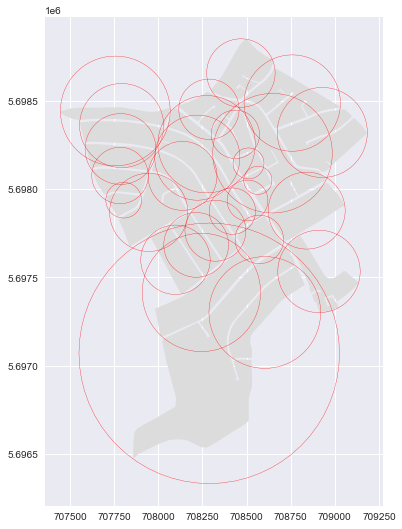

In [20]:
ax = city_blocks_prj.plot(figsize=(10,9), color='gainsboro')
city_blocks_form_factor.plot(ax=ax, facecolor='none', edgecolor='red')

# OSMuf Plots
To facilitate visual comparison between the different sample areas, OSMuf produces a set of standard visualisations.

## 1. Block Size
The first visualisation presents the urban blocks cropped to a fixed 1km x 1km bounding box. This allows a consistent visual comparison of block size and shape between sample areas. The blocks are annotated with their net:gross area ratio and their net and gross areas in hectares.

The top graph plots the net:gross area ratio against block size. This gives an indication of the proportion of land that is developable and the proportion that is public highway.

The bottom graph shows a distribution of block sizes primarily to facilitate comparison between sample areas.

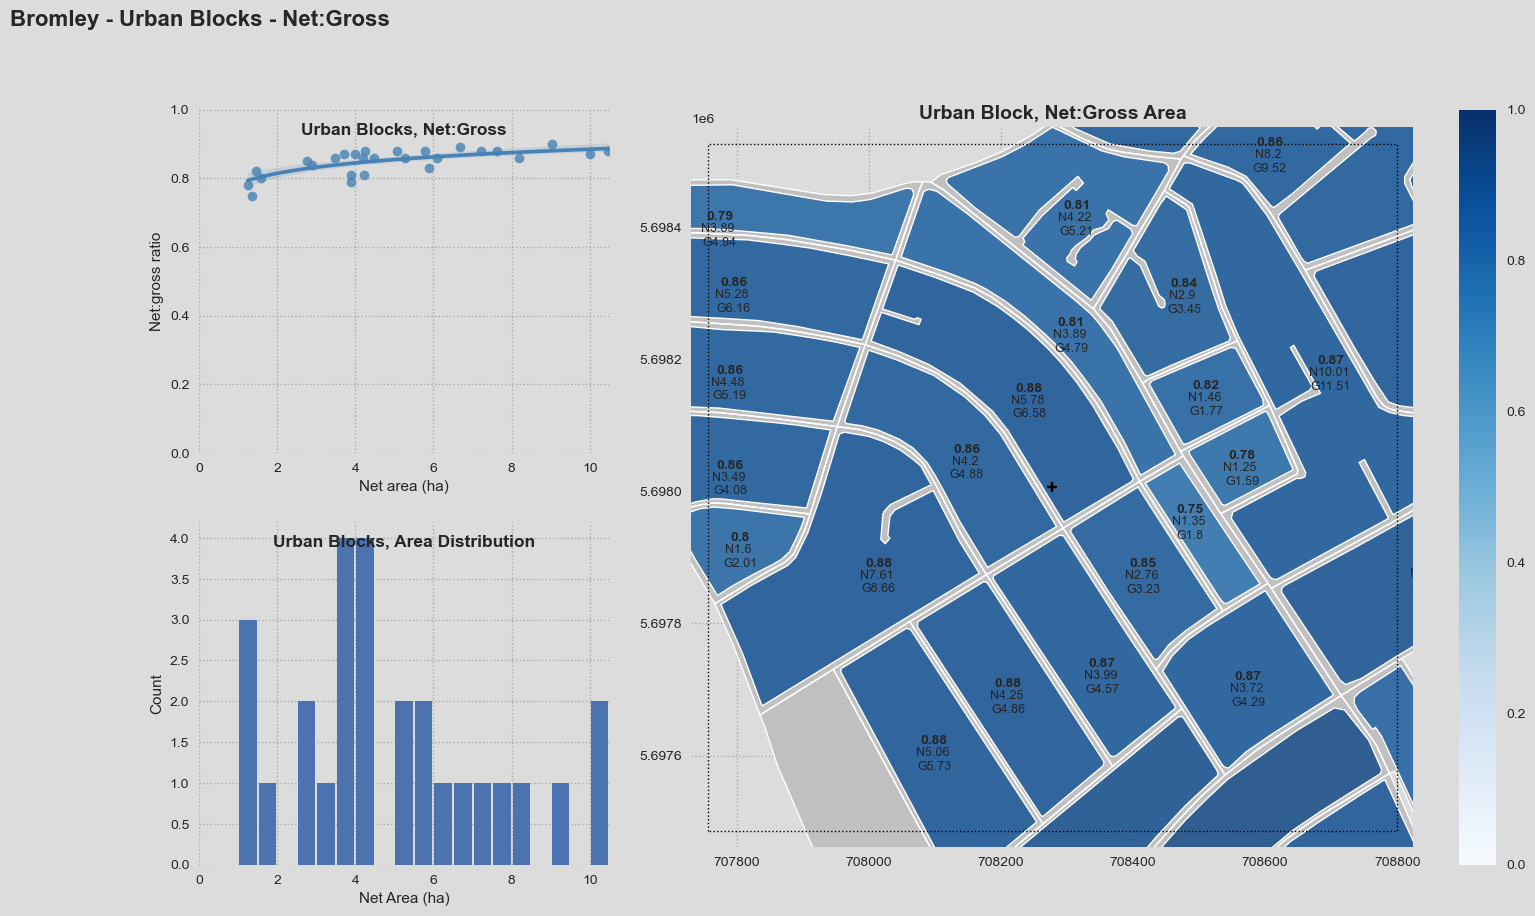

In [22]:
fig, ax = ouf.layout_3_plots(dpi=dpi)
fig.suptitle(place_name + ' - Urban Blocks - Net:Gross',
             fontsize=16, fontweight='bold', ha='left', x=0.02)

ouf.ax_block_ntg_to_size(ax[0], city_blocks_prj)

ouf.ax_block_area_distribution(ax[1], city_blocks_prj)

ouf.ax_map_block_size(ax[2], study_area_prj,
                      gross_city_blocks_prj, city_blocks_prj)

fig.savefig('../00_blocks_size_{}.png'.format(place_name),
            transparent=False, dpi=dpi, bbox_inches="tight",
            facecolor='gainsboro')

## 2. Block Shape
There are many different ways of quantifying the shape of polygons. OSMuf focuses on the perimeter:area ratio.

The top graph plots each block's perimeter length against its net area. The red line shows the relationship for perfectly square blocks.

The bottom graph plots the form-factor.

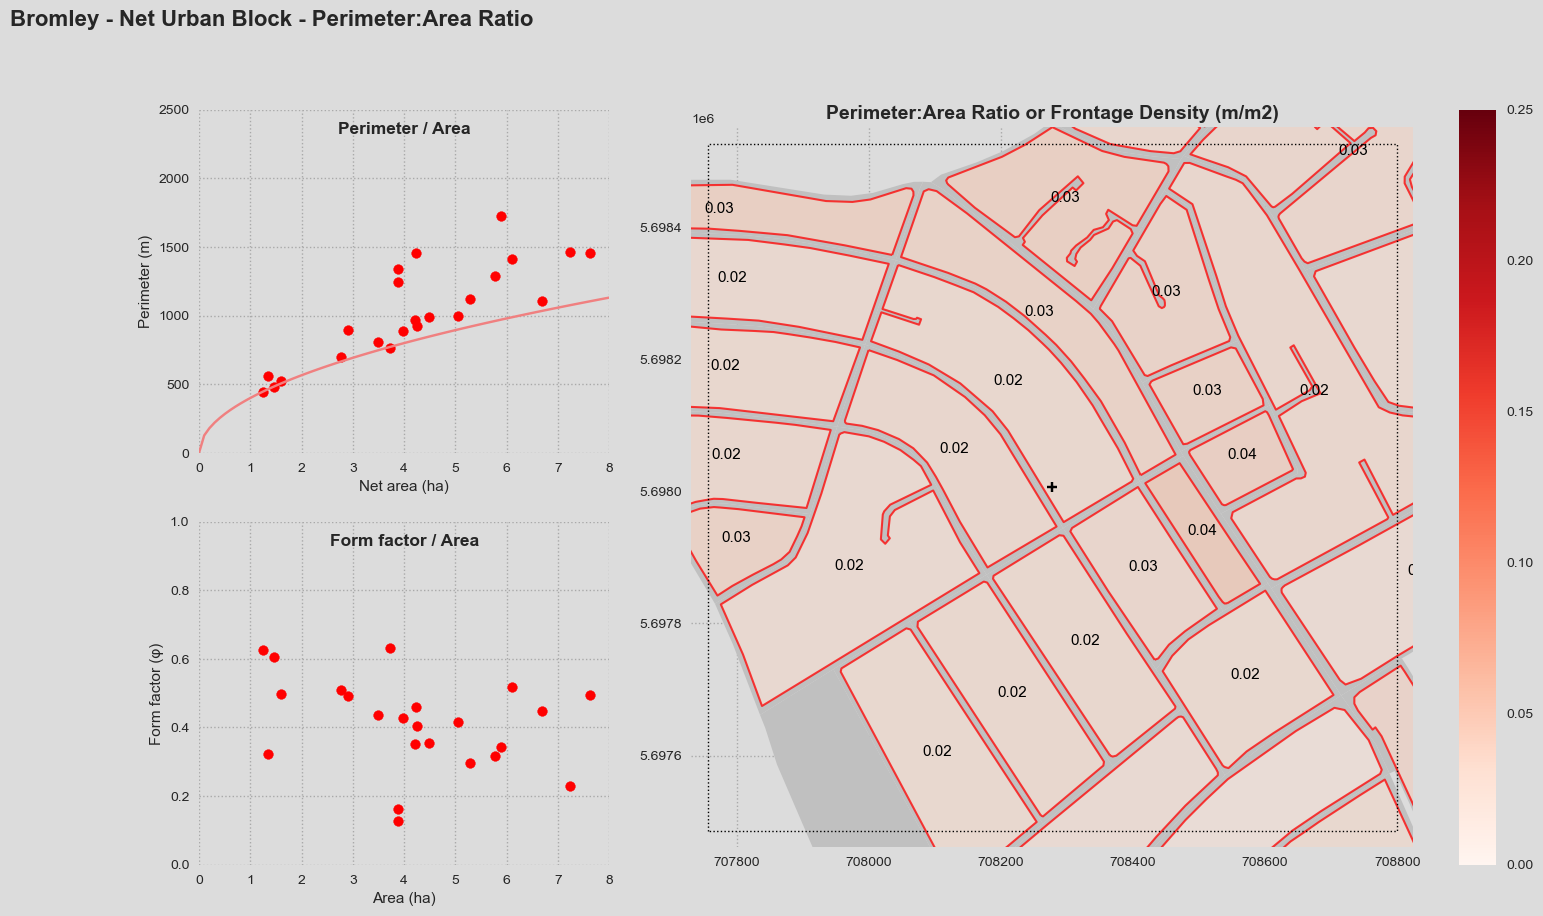

In [23]:
fig, ax = ouf.layout_3_plots(dpi=dpi)
fig.suptitle(place_name + ' - Net Urban Block - Perimeter:Area Ratio',
             fontsize=16, fontweight='bold', ha='left', x=0.02)

ouf.ax_block_perimeter_to_area(ax[0], city_blocks_prj)
ouf.ax_form_factor_to_area(ax[1], city_blocks_form_factor)
ouf.ax_map_form_factor(ax[2], study_area_prj, gross_city_blocks_prj,
                       city_blocks_prj, city_blocks_form_factor)

fig.savefig('../01_blocks_form_factor_{}.png'.format(place_name),
            transparent=False, dpi=dpi, bbox_inches="tight",
            facecolor='gainsboro')

# 3. Block GSI
Site coverage, also known as the Ground Space Index (GSI), measures the proportion of an area of land that is covered by buildings. The map below shows that for this sample area in Bromley, London, about 15% of each net urban block is covered by buildings.

Plotting the GSI against the net area of each urban block shows a gentle fall in this measure of building density as the block size grows.

The bottom graph conversely shows that as the blocks' frontage density rises so does the GSI measure of building density.

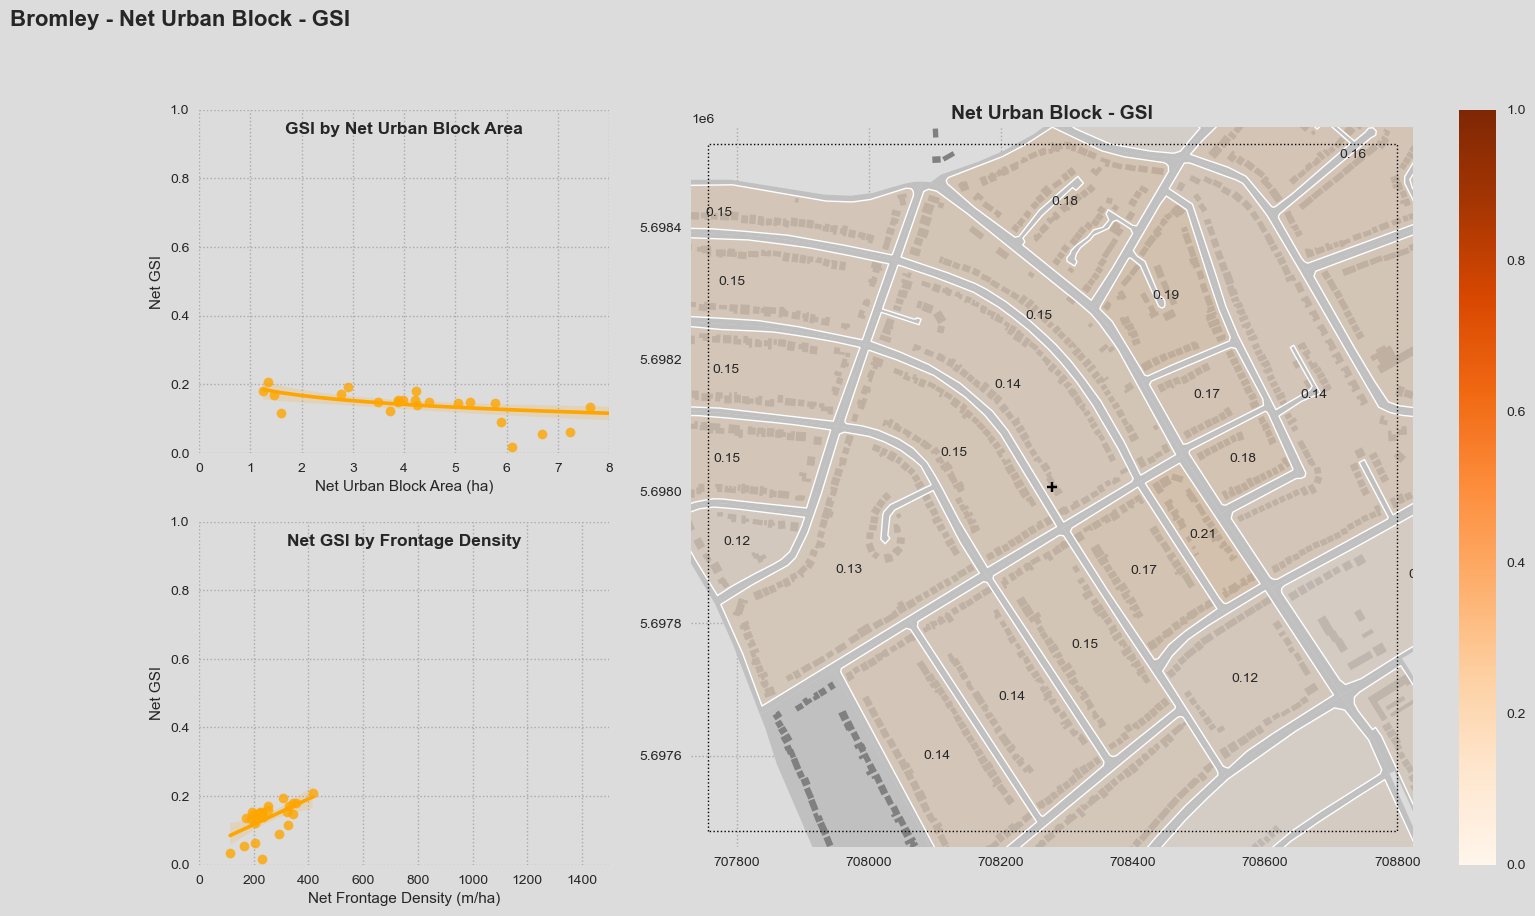

In [24]:
fig, ax = ouf.layout_3_plots(dpi=dpi)
fig.suptitle(place_name + ' - Net Urban Block - GSI', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

ouf.ax_net_GSI_to_net_area(ax[0], city_blocks_prj)
#ouf.ax_building_footprint_to_net_area(ax[0], city_blocks_prj)
ouf.ax_net_GSI_to_frontage_density(ax[1], city_blocks_prj)
#ouf.ax_GSI_distribution(ax[1], city_blocks_prj)
ouf.ax_map_GSI(ax[2], study_area_prj, gross_city_blocks_prj,
               city_blocks_prj, buildings_prj)

fig.savefig('../02_blocks_by_GSI_{}.png'.format(place_name),
            transparent=False, dpi=dpi, bbox_inches="tight",
            facecolor='gainsboro')

# 4. Building Heights
Building height significantly affects measured building density. Wide variation in building heights within blocks makes it harder to identify the effect of street network density on building density.

/home/nick/anaconda3/envs/osmuf-dev/lib/python3.7/site-packages/patsy/constraint.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


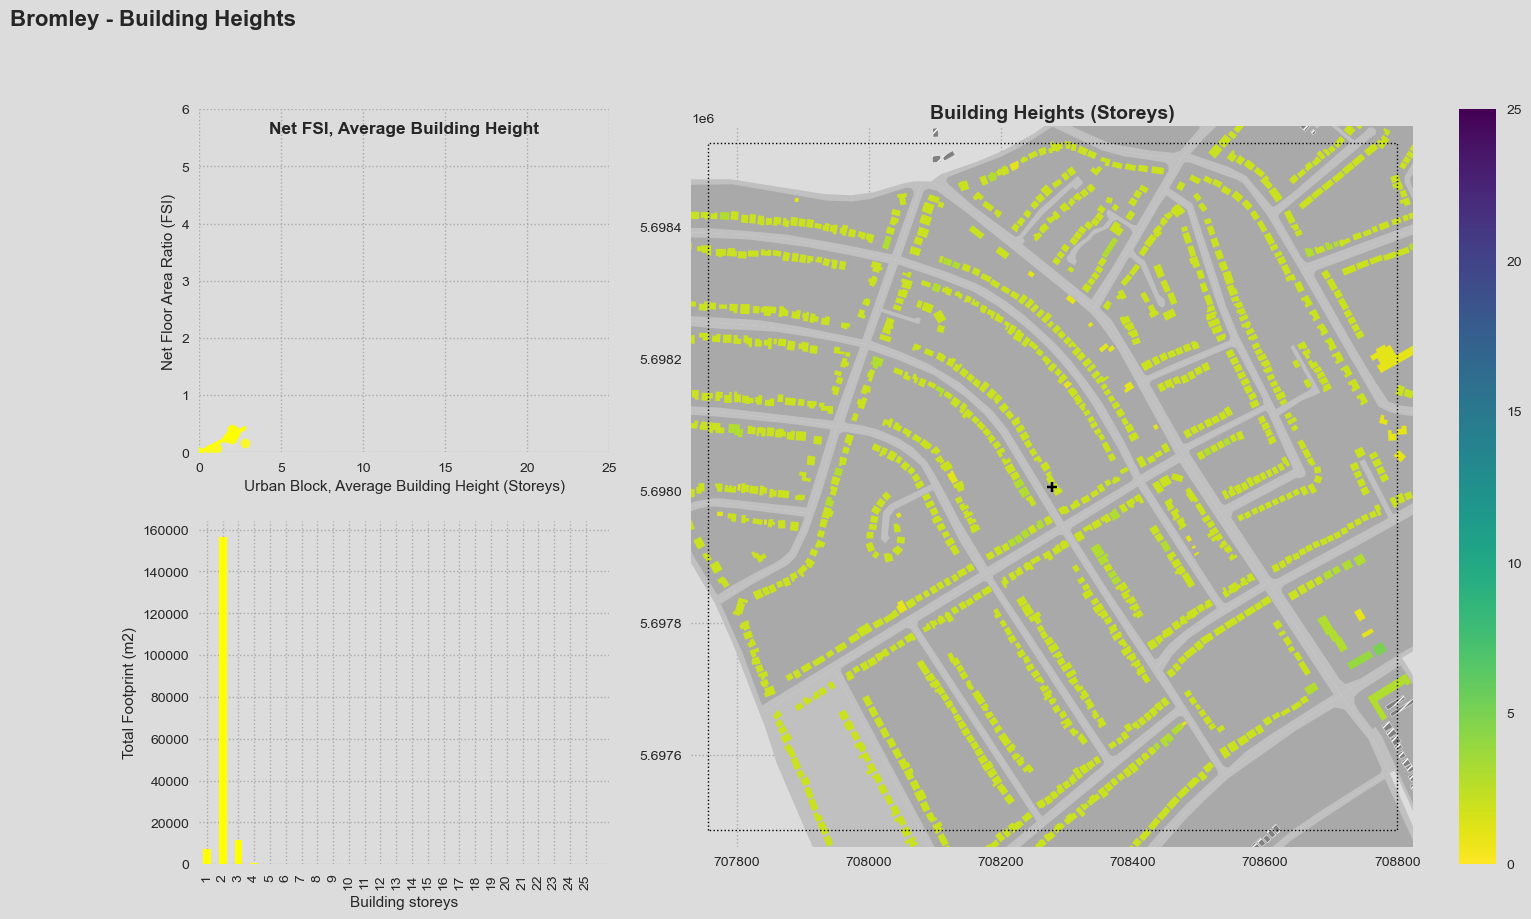

In [25]:
fig, ax = ouf.layout_3_plots(dpi=dpi)
fig.suptitle(place_name + ' - Building Heights', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

ouf.ax_net_FSI_to_avg_building_height(ax[0], city_blocks_prj)
ouf.ax_building_height_distribution_by_area(ax[1], buildings_prj)
ouf.ax_map_building_heights(ax[2], study_area_prj, gross_city_blocks_prj,
                            city_blocks_prj, buildings_prj)

fig.savefig('../04_building_heights_{}.png'.format(place_name),
            transparent=False, dpi=dpi, bbox_inches="tight",
            facecolor='gainsboro')

# 5. Block FSI
Floor Space Index (FSI), also known as Floor Area Ratio, is the ratio of the total gross floor area of all of the buildings on the block to the net area of the block. 

This is the cumulative building density measure which assesses the total quantity of above-ground building relative to the area of each urban block.

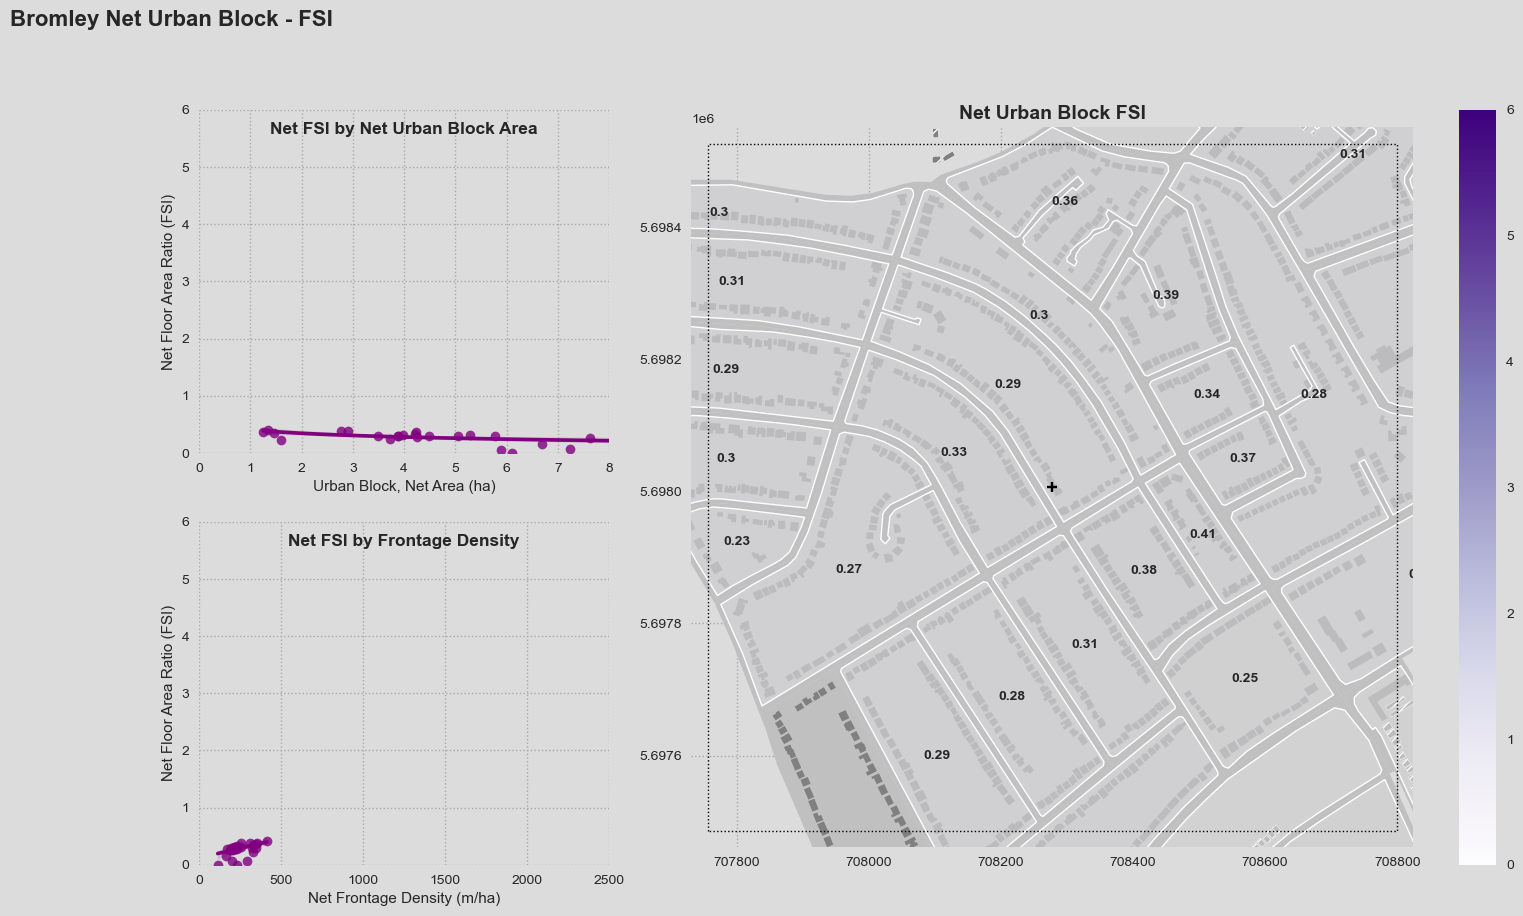

In [26]:
fig, ax = ouf.layout_3_plots(dpi=dpi)
fig.suptitle(place_name + ' Net Urban Block - FSI', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

# ouf.ax_gross_FSI_to_gross_area(ax[0], city_blocks_prj)
#ouf.ax_building_GEA_to_net_area(ax[0], city_blocks_prj)
ouf.ax_net_FSI_to_net_area(ax[0], city_blocks_prj)
###ouf.ax_gross_FSI_to_gross_frontage_density(ax[0], city_blocks_prj)
ouf.ax_net_FSI_to_frontage_density(ax[1], city_blocks_prj)
#ouf.ax_building_GEA_to_frontage(ax[1], city_blocks_prj)
ouf.ax_map_FSI(ax[2], study_area_prj, gross_city_blocks_prj,
               city_blocks_prj, buildings_prj)

fig.savefig('../04_blocks_by_FSI_{}.png'.format(place_name),
            transparent=False, dpi=dpi, bbox_inches="tight",
            facecolor='gainsboro')

# 6. Network Density
The map shows the length of the street network (m) relative to the gross area of the urban block (ha).

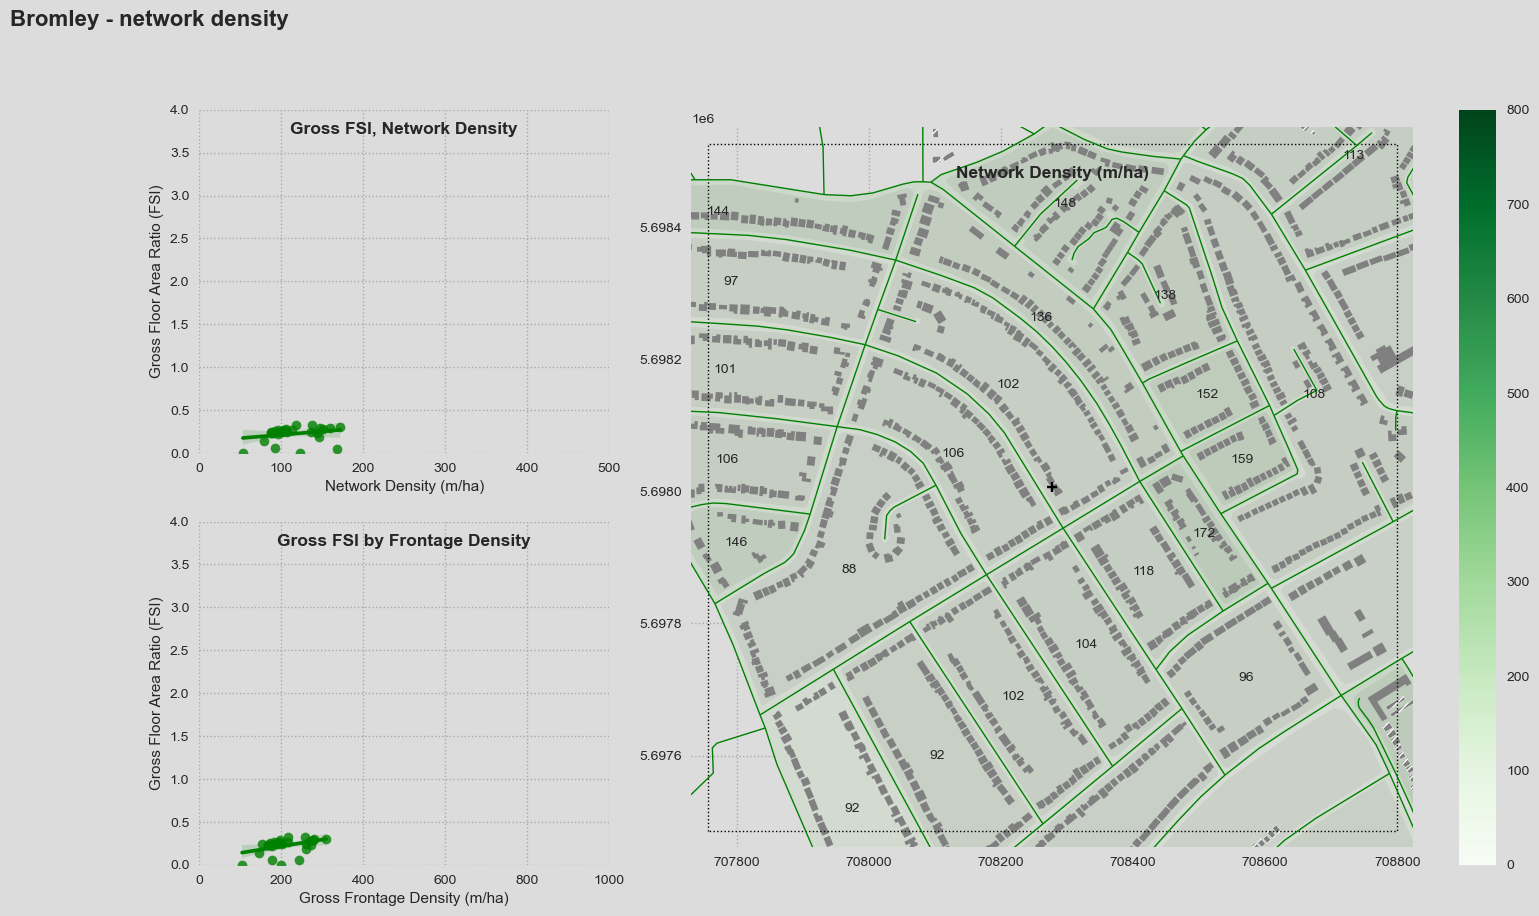

In [27]:
fig, ax = ouf.layout_3_plots(dpi=dpi)
fig.suptitle(place_name + ' - network density', fontsize=16,
             fontweight='bold', ha='left', x=0.02)

# ouf.ax_gross_FSI_to_gross_area(ax[0], city_blocks_prj)
ouf.ax_gross_FSI_to_network_density(ax[0], city_blocks_prj)
### ouf.ax_network_density_to_gross_area(ax[1], gross_city_blocks_prj)
ouf.ax_gross_FSI_to_gross_frontage_density(ax[1], city_blocks_prj)
ouf.ax_map_network_density(ax[2], study_area_prj, gross_city_blocks_prj,
                           city_blocks_prj, buildings_prj,
                           streets_for_networkd_prj)

fig.savefig('../06_network_density_{}.png'.format(place_name),
            transparent=False, dpi=dpi, bbox_inches="tight",
            facecolor='gainsboro')